<a id='top'></a>

# What can an Airbnb host do to maximize occupancy?

#### Using data from Airbnb, I developed a model that predicts which properties will have occupancy rates of 75% over the next  60 days

- [Step 1](#Step_1) Preprocessing: Format and edit the data. After reviewing the 105 variables in the data, I selected 29 to use to build a model.
- [Step 2](#Step_2) Examine value counts of categorical variables to create meaningful categories where possible.
- [Step 3](#Step_3) Feature engineering: Number of amenities; price per person; and bathrooms, bedrooms, and beds per person.
- [Step 4](#Step_4) Format data for EDA and analysis: Convert categorical variables to categorical data types, code target.
- [Step 5](#Step_5) Housekeeping: Save dataframe with variables that will be useful for different, future analysis; drop variables no longer needed.
- [Step 6](#Step_6) EDA: Descriptives, grouped by data type and content.
- [Step 7](#Step_7) Identify outliers for removal by creating boxplots.
- [Step 8](#Step_8) Implement random forests with basic train/test split.
- [Step 9](#Step_9) Identify most important features.

In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)
pd.options.display.max_rows = 999
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import datetime as dt
from datetime import datetime
from datetime import timedelta 
import plotly.graph_objects as go

<a id='Step_1'></a>

#### Step 1: Preprocessing: Format and edit data
I transformed text data to numeric data, reviewed NaNs and edited data to remove cases with missing data, and created datetime variables to edit data to remove inactive listings and for future feature engineering (i.e., number of reviews per month), 

In [2]:
file_loc = "C:/Users/rmbrm/Documents/pathrise_challenge/listings.csv"
df = pd.read_csv(file_loc, index_col=None, na_values=['NA'], usecols = ['host_since', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price', 'cleaning_fee', 'guests_included', 'extra_people', 'availability_60', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification', 'amenities'])


In [3]:
# Text to numeric

df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].astype(float)

df['cleaning_fee'] = df['cleaning_fee'].str.replace(',', '')
df['cleaning_fee'] = df['cleaning_fee'].str.replace('$', '')
df['cleaning_fee'] = df['cleaning_fee'].astype(float)

df['extra_people'] = df['extra_people'].str.replace(',', '')
df['extra_people'] = df['extra_people'].str.replace('$', '')
df['extra_people'] = df['extra_people'].astype(float)

df.replace(to_replace ="t", value ="1", inplace = True) 
df.replace(to_replace ="f", value ="0", inplace = True) 

In [4]:
# Look at NaN

df.isnull().sum()

host_since                            12
host_is_superhost                     12
host_has_profile_pic                  12
host_identity_verified                12
property_type                          0
room_type                              0
accommodates                           0
bathrooms                              6
bedrooms                               8
beds                                   8
bed_type                               0
amenities                              0
price                                  0
cleaning_fee                        3721
guests_included                        0
extra_people                           0
availability_60                        0
number_of_reviews                      0
first_review                        2593
last_review                         2593
review_scores_accuracy              2827
review_scores_cleanliness           2825
review_scores_checkin               2837
review_scores_communication         2830
review_scores_lo

In [5]:
df.shape

(20677, 29)

In [6]:
# Drop rows with missing data

df.dropna(subset=["review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication",
                  "review_scores_location", "review_scores_value", "host_is_superhost", "host_has_profile_pic",
                  "host_identity_verified", "first_review", "last_review", "bathrooms", "bedrooms", "beds"], inplace=True)

df.shape

(17811, 29)

In [7]:
# Transform date variables to datetime to be used for data editing, and feature engineering for future analysis

df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])
df['host_since'] = pd.to_datetime(df['host_since'])

In [8]:
# Create a variable showing how recent the last review for the property was

df['old'] = datetime.today() - df['last_review']
df['old_days'] = (df['old']  / np.timedelta64(1, 'D')).astype(int)

In [9]:
df.shape

(17811, 31)

In [10]:
# Delete listings for which the most recent review was 1.5 years ago

df = df[df.old_days < 547]

df.shape

(13462, 31)

Back to [top](#top) 

<a id='Step_2'></a>

#### Step 2: Examine value counts of categorical variables to create meaningful categories where possible.

In [11]:
df['property_type'].value_counts()

Apartment                 10021
House                       972
Townhouse                   481
Bed and breakfast           476
Loft                        331
Boat                        268
Houseboat                   259
Condominium                 214
Guest suite                 139
Aparthotel                   63
Serviced apartment           45
Guesthouse                   40
Villa                        26
Boutique hotel               26
Hostel                       22
Other                        21
Hotel                        14
Tiny house                   10
Cottage                       9
Cabin                         7
Chalet                        3
Bungalow                      3
Barn                          2
Camper/RV                     2
Casa particular (Cuba)        2
Dome house                    1
Nature lodge                  1
Campsite                      1
Tent                          1
Island                        1
Castle                        1
Name: pr

In [12]:
df['room_type'].value_counts()

Entire home/apt    10379
Private room        3031
Shared room           52
Name: room_type, dtype: int64

In [13]:
df['bed_type'].value_counts()

Real Bed         13354
Pull-out Sofa       74
Futon               24
Airbed               6
Couch                4
Name: bed_type, dtype: int64

In [14]:
# Based on above results, for two features code data into three categories

def recode_p(property):
    if property == 'Apartment':
        return 1
    elif property == 'House':
        return 2
    else:
        return 3

# recode room type
def recode_r(room):
    if room == 'Entire home/apt':
        return 1
    elif room == 'Private room':
        return 2
    else:
        return 3

df['property_code'] = df.apply(lambda x: recode_p(x['property_type']), axis=1)
df['room_code'] = df.apply(lambda x: recode_r(x['room_type']), axis =1)

Back to [top](#top) 

<a id='Step_3'></a>

#### Step 3: Feature engineering: Number of amenities; price per person; and bathrooms, bedrooms, and beds per person.

In [15]:
# Create a feature of the number of amenities at a property

df['amen_count']=(df['amenities'].str.count(',') + 1)

In [16]:
# Using price, number of guests, number of property characteristics, create features for price per person,
# bathrooms per person, bedrooms per person, and beds per person

df['price_per_person'] = df['price']/df['guests_included']
df['bathrooms_per_person'] = df['bathrooms']/df['guests_included']
df['bedrooms_per_person'] = df['bedrooms']/df['guests_included']
df['beds_per_person'] = df['beds']/df['guests_included']

Back to [top](#top) 

<a id='Step_4'></a>

#### Step 4: Format data for EDA and analysis: Convert categorical variables to categorical data types, code target.


In [17]:
# Code target: Listings with availability of two weeks or less out of 60 days, i.e., listings that have high rental rates

def recode(days):
    if days < 15:
        return 1
    else:
        return 0

df['target'] = df.apply(lambda x: recode(x['availability_60']), axis=1)


In [18]:
# Convert string vars to categoricals

df[["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "instant_bookable", 
    "require_guest_profile_picture", "require_guest_phone_verification", "property_code", "room_code", "target"]]= df[["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "instant_bookable", 
      "require_guest_profile_picture", "require_guest_phone_verification", "property_code", "room_code", 
      "target"]].astype('category')

Back to [top](#top) 

<a id='Step_5'></a>

#### Step 5, housekeeping: Save dataframe with variables that will be useful for different, future analysis; drop variables no longer needed.

In [19]:
# Drop variables that are no longer needed and save version of df with extra variables for future analysis

df.drop(['amenities', 'property_type', 'room_type', 'bed_type', 'old', "bathrooms", "bedrooms", "beds", "availability_60"],axis=1, inplace=True)

df.to_pickle ("C:/Users/rmbrm/Documents/pathrise_challenge/data_clean_vars_for_future", compression='infer', protocol=4)
df.to_excel ("C:/Users/rmbrm/Documents/pathrise_challenge/data_clean_vars_for_future.xlsx")

In [20]:
# Drop variables that are not needed for this analysis and save df with just data for this analysis

df.drop(["host_since", "price", "accommodates", "cleaning_fee", "guests_included", "extra_people", "number_of_reviews",
         "first_review", "last_review"], axis=1, inplace=True)

df.to_pickle ("C:/Users/rmbrm/Documents/pathrise_challenge/data", compression='infer', protocol=4)
df.to_excel ("C:/Users/rmbrm/Documents/pathrise_challenge/data.xlsx")

Back to [top](#top) 

<a id='Step_6'></a>

#### Step 6, EDA: Descriptives, grouped by data type and content.

In [21]:
# Categorical variables descriptives

df[["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "instant_bookable", 
    "require_guest_profile_picture", "require_guest_phone_verification", "property_code", "room_code", 'target']].describe()

,host_is_superhost,host_has_profile_pic,host_identity_verified,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,property_code,room_code,target
count,13462,13462,13462,13462,13462,13462,13462,13462,13462
unique,2,2,2,2,2,2,3,3,2
top,0,1,0,0,0,0,1,1,1
freq,10377,13459,8122,9643,13292,13231,10021,10379,10490


In [22]:
# Continuous variables summarizing reviews

df[["review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", 
     "review_scores_communication", "review_scores_location", "review_scores_value"]].describe()

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,13462.000000,13462.000000,13462.000000,13462.000000,13462.000000,13462.000000
mean,9.722627,9.508394,9.765339,9.816743,9.529193,9.187862
std,0.628324,0.794947,0.618278,0.561691,0.645225,0.757495
min,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000
50%,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000
75%,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [23]:
# Other continuous variables

df[["amen_count", "price_per_person", "bathrooms_per_person", "bedrooms_per_person", "beds_per_person"]].describe()

,amen_count,price_per_person,bathrooms_per_person,bedrooms_per_person,beds_per_person
count,13462.000000,13462.000000,13462.000000,13462.000000,13462.000000
mean,22.625539,123.173858,0.928547,1.111660,1.384833
std,10.204547,98.217302,0.436495,0.766577,1.068454
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,70.000000,0.500000,0.666667,1.000000
50%,21.000000,100.000000,1.000000,1.000000,1.000000
75%,29.000000,150.000000,1.000000,1.000000,2.000000
max,74.000000,5040.000000,15.000000,12.000000,32.000000


Back to [top](#top) 

<a id='Step_7'></a>

#### Step 7: Identify outliers for removal by creating boxplots.

Interactive boxplots were created with Plotly, so that data is viewable on hover. Please click the link below to view boxplots.

[box_plots](https://nbviewer.jupyter.org/github/RossBrownPhD/Work_Samples_and_Resume/blob/5d34106c072f5e2c3363fa6ea1c243390c3bf928/Ross_Brown_Pathrise_Challenge_Boxplots.ipynb)

In [24]:
# Remove cases based on boxplots

df.shape

(13462, 21)

In [25]:
df = df[df.amen_count < 69]
df = df[df.price_per_person < 2001] 
df = df[df.bathrooms_per_person < 4] 
df = df[df.bedrooms_per_person < 5] 
df = df[df.beds_per_person < 5] 

df.shape

(13249, 21)

Back to [top](#top) 

<a id='Step_8'></a>

#### Step 8: Implement random forests with basic train/test split.

In [26]:
# Convert categorical vars to ints for machine learning

df[["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "instant_bookable", 
    "require_guest_profile_picture", "require_guest_phone_verification", "property_code", "room_code", "target"]]= df[["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "instant_bookable", 
      "require_guest_profile_picture", "require_guest_phone_verification", "property_code", "room_code", 
      "target"]].astype('int')

In [27]:
# Remove leaking feature

df.drop(['old_days'], axis=1, inplace = True)

In [28]:
features = df.drop(df.columns[19], axis=1).values 
target = df['target'].values

type (features), type(target)

(numpy.ndarray, numpy.ndarray)

In [29]:
print(features)

[[0.         1.         1.         ... 0.33333333 0.33333333 0.66666667]
 [0.         1.         0.         ... 1.         1.         1.        ]
 [0.         1.         1.         ... 1.5        3.         4.        ]
 ...
 [1.         1.         1.         ... 1.         2.         1.        ]
 [0.         1.         0.         ... 0.5        0.5        0.5       ]
 [0.         1.         0.         ... 1.         1.         1.        ]]


In [30]:
print(target)

[1 0 1 ... 1 1 1]


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 42)
forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score( X_test, y_test)))

Accuracy on training set: 0.998
Accuracy on test set: 0.785


Back to [top](#top) 

<a id='Step_9'></a>

#### Step 9: Identify most important features.

Feature ranking:
1. feature 15 (0.238847)
2. feature 14 (0.205282)
3. feature 13 (0.068843)
4. feature 16 (0.064504)
5. feature 18 (0.057069)
6. feature 17 (0.049747)
7. feature 4 (0.043436)
8. feature 12 (0.039789)
9. feature 7 (0.037077)
10. feature 8 (0.035065)
11. feature 2 (0.033145)
12. feature 3 (0.025840)
13. feature 5 (0.024622)
14. feature 9 (0.023755)
15. feature 0 (0.021996)
16. feature 6 (0.020854)
17. feature 11 (0.005830)
18. feature 10 (0.004167)
19. feature 1 (0.000135)


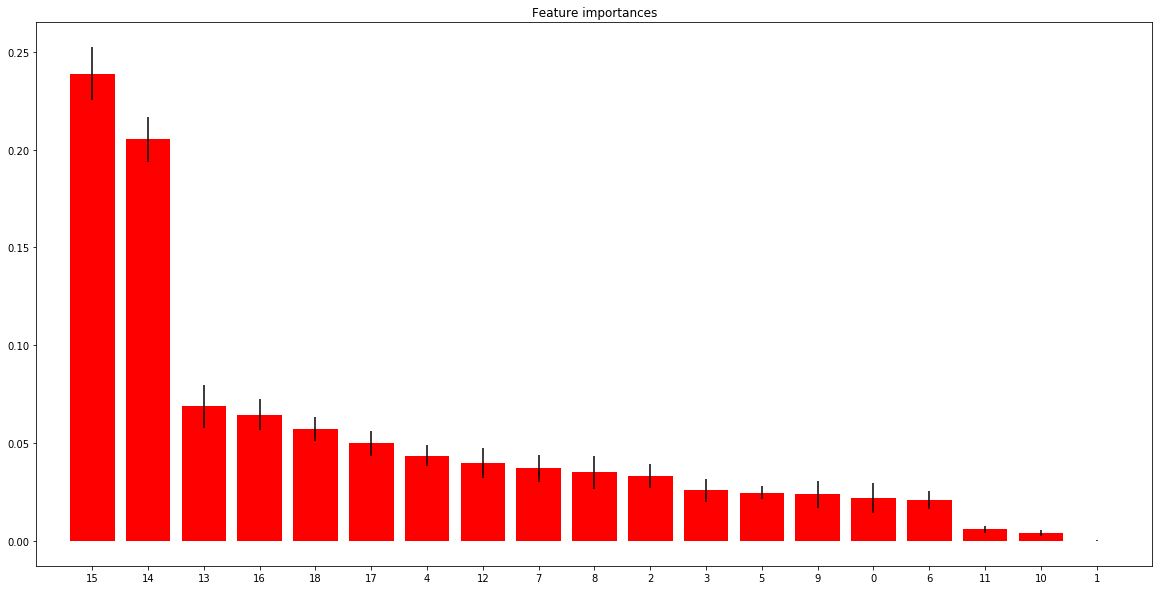

In [32]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

| Feature                                        | Proportion of effect on target     |
|------------------------------------------------|------------------------------------|
|  Price per person                              | 0.24                               |
|------------------------------------------------|------------------------------------|
|  Number of amenities                           | 0.21                               |
|------------------------------------------------|------------------------------------|
|  Type of room                                  | 0.07                               |
|------------------------------------------------|------------------------------------|
|  Bathrooms per person                          | 0.06                               |
|------------------------------------------------|------------------------------------|
|  Beds per person                               | 0.06                               |
|------------------------------------------------|------------------------------------|
|  Bedrooms per person                           | 0.05                               |
|------------------------------------------------|------------------------------------|
|  Reviews score for cleanliness                 | 0.04                               |
|------------------------------------------------|------------------------------------|
|  Type of property                              | 0.04                               |
|------------------------------------------------|------------------------------------|
|  Reviews score for location                    | 0.04                               |
|------------------------------------------------|------------------------------------|
|  Reviews score for value                       | 0.04                               |
|------------------------------------------------|------------------------------------|
|  Host identity verified                        | 0.03                               |
|------------------------------------------------|------------------------------------|
|  Reviews score for accuracy                    | 0.03                               |
|------------------------------------------------|------------------------------------|
|  Reviews score for check in                    | 0.02                               |
|------------------------------------------------|------------------------------------|
|  Instantly bookable                            | 0.02                               |
|------------------------------------------------|------------------------------------|
|  Host is superhost                             | 0.02                               |
|------------------------------------------------|------------------------------------|
|  Reviews score for communication               | 0.02                               |
|------------------------------------------------|------------------------------------|
|  Require guest phone verification              | 0.01                               |
|------------------------------------------------|------------------------------------|
|  Require guest profile picture                 | 0.00                               |
|------------------------------------------------|------------------------------------|
|  Host has profile picture                      | 0.00                               |
|------------------------------------------------|------------------------------------|


Back to [top](#top) 